# Energy Project — Immediate-Execution Notebook (Python 3.9)

Run these cells **top-to-bottom**. No helper functions or CLIs — each cell *does the work* immediately.


## 1) Parameters & Setup

In [1]:
# ---- Paths / Columns ----
from pathlib import Path

PROJECT_ROOT = Path.cwd()
RAW_DATA_PATH = PROJECT_ROOT / "data" / "energy_weather_raw_data.csv"  # change if needed
MODEL_DIR = PROJECT_ROOT / "models"; MODEL_DIR.mkdir(exist_ok=True)

DATE_COLUMN   = "date"
TARGET_COLUMN = "active_power"

# ---- Feature engineering ----
LAG_STEPS = 24  # number of lag steps for target

# ---- Split ratios (chronological) ----
TEST_FRACTION = 0.20
VAL_FRACTION  = 0.10

print("Project root:", PROJECT_ROOT)
print("Data CSV:", RAW_DATA_PATH, "| Exists:", RAW_DATA_PATH.exists())
print("Models dir:", MODEL_DIR)

Project root: d:\SEM_3_SETU\codes\project-shon\C00313480_power_consumption\C00313480_power_consumption
Data CSV: d:\SEM_3_SETU\codes\project-shon\C00313480_power_consumption\C00313480_power_consumption\data\energy_weather_raw_data.csv | Exists: True
Models dir: d:\SEM_3_SETU\codes\project-shon\C00313480_power_consumption\C00313480_power_consumption\models


## 2) Data Ingest + Clean (runs immediately)

In [2]:
import pandas as pd

csv_path = RAW_DATA_PATH
if not csv_path.exists():
    raise FileNotFoundError(
        f"Data file not found: {csv_path}\n"
        "➡️ Place your CSV there, or update RAW_DATA_PATH above."
    )

# Load CSV and set DateTimeIndex
df_raw = pd.read_csv(csv_path)
df_raw[DATE_COLUMN] = pd.to_datetime(df_raw[DATE_COLUMN])
df_raw = df_raw.set_index(DATE_COLUMN).sort_index()

# Clean: aggregate per timestamp (mean for numeric, first for others)
num_cols = df_raw.select_dtypes(include="number").columns
other_cols = df_raw.columns.difference(num_cols)

df_num   = df_raw[num_cols].groupby(df_raw.index).mean()
df_other = df_raw[other_cols].groupby(df_raw.index).first()

df = pd.concat([df_num, df_other], axis=1).sort_index()

# Hourly frequency + interpolate numeric gaps
df = df.asfreq("H")
df[num_cols] = df[num_cols].interpolate("time")

# Drop rows where target is missing
if TARGET_COLUMN not in df.columns:
    raise KeyError(f"TARGET_COLUMN '{TARGET_COLUMN}' not found in columns: {list(df.columns)[:10]} ...")
df = df.dropna(subset=[TARGET_COLUMN])

print("✓ Loaded & cleaned.")
print("Raw shape:", df_raw.shape, "| Clean shape:", df.shape)
print("Columns (first 15):", list(df.columns)[:15])

display(df.head())

✓ Loaded & cleaned.
Raw shape: (605260, 18) | Clean shape: (10234, 18)
Columns (first 15): ['active_power', 'current', 'voltage', 'reactive_power', 'apparent_power', 'power_factor', 'temp', 'feels_like', 'temp_min', 'temp_max', 'pressure', 'humidity', 'speed', 'deg', 'temp_t+1']


,active_power,current,voltage,reactive_power,apparent_power,power_factor,temp,feels_like,temp_min,temp_max,pressure,humidity,speed,deg,temp_t+1,feels_like_t+1,description,main
date,,,,,,,,,,,,,,,,,,
2022-11-05 14:05:00,265.1,2.53,122.2,159.09,309.17,0.8575,24.19,23.68,23.44,27.50,1013.0,39.0,0.00,0.0,29.63,27.97,clear sky,Clear
2022-11-05 15:05:00,173.0,1.52,122.5,68.86,186.20,0.9291,24.27,23.72,24.25,27.50,1007.0,37.0,3.32,350.0,29.23,27.54,clear sky,Clear
2022-11-05 16:05:00,168.0,2.04,122.5,185.00,249.90,0.6723,23.73,23.12,23.70,26.96,1007.0,37.0,0.45,75.0,30.33,28.40,clear sky,Clear
2022-11-05 17:05:00,190.5,2.03,122.9,161.11,249.49,0.7636,24.05,23.48,23.70,26.39,1012.0,37.0,2.57,360.0,29.23,27.55,clear sky,Clear
2022-11-05 18:05:00,586.8,5.13,121.5,210.13,623.29,0.9415,22.59,21.87,22.50,22.59,1008.0,37.0,1.88,17.0,28.43,27.42,clear sky,Clear


## 3) Feature Engineering (runs immediately)

In [3]:
import numpy as np

if "df" not in globals():
    raise RuntimeError("df not found. Run the ingest/clean cell first.")

before_rows = len(df)
df_fe = df.copy()

# Time features
df_fe["hour"]  = df_fe.index.hour
df_fe["dow"]   = df_fe.index.dayofweek
df_fe["month"] = df_fe.index.month

# Cyclic encodings
df_fe["hour_sin"] = np.sin(2 * np.pi * df_fe["hour"] / 24)
df_fe["hour_cos"] = np.cos(2 * np.pi * df_fe["hour"] / 24)
df_fe["dow_sin"]  = np.sin(2 * np.pi * df_fe["dow"] / 7)
df_fe["dow_cos"]  = np.cos(2 * np.pi * df_fe["dow"] / 7)

# Lag features for target
lags = list(range(1, int(LAG_STEPS) + 1))
for lag in lags:
    df_fe[f"{TARGET_COLUMN}_lag_{lag}"] = df_fe[TARGET_COLUMN].shift(lag)

# Drop rows made NaN by lags
df_fe = df_fe.dropna()

# Replace df with engineered version
df = df_fe

after_rows = len(df)
print("✓ Feature engineering complete.")
print(f"Rows before: {before_rows:,} | after: {after_rows:,} | dropped: {before_rows - after_rows:,}")
print("Added columns (sample):", 
      [c for c in df.columns if c.endswith(('_sin','_cos')) or '_lag_' in c][:10], "...")

display(df.head())

✓ Feature engineering complete.
Rows before: 10,234 | after: 10,058 | dropped: 176
Added columns (sample): ['hour_sin', 'hour_cos', 'dow_sin', 'dow_cos', 'active_power_lag_1', 'active_power_lag_2', 'active_power_lag_3', 'active_power_lag_4', 'active_power_lag_5', 'active_power_lag_6'] ...


,active_power,current,voltage,reactive_power,apparent_power,power_factor,temp,feels_like,temp_min,temp_max,...,active_power_lag_15,active_power_lag_16,active_power_lag_17,active_power_lag_18,active_power_lag_19,active_power_lag_20,active_power_lag_21,active_power_lag_22,active_power_lag_23,active_power_lag_24
date,,,,,,,,,,,,,,,,,,,,,
2022-11-06 14:05:00,102.3,1.10,123.2,88.88,135.52,0.7549,29.23,27.55,27.67,29.25,...,244.2,322.2,124.4,131.5,409.9,586.8,190.5,168.0,173.0,265.1
2022-11-06 15:05:00,83.1,0.85,123.1,63.58,104.63,0.7942,28.69,27.16,28.23,28.70,...,290.9,244.2,322.2,124.4,131.5,409.9,586.8,190.5,168.0,173.0
2022-11-06 16:05:00,392.7,3.69,122.5,223.85,452.02,0.8688,27.59,26.40,27.59,28.62,...,383.7,290.9,244.2,322.2,124.4,131.5,409.9,586.8,190.5,168.0
2022-11-06 17:05:00,357.4,3.44,122.7,224.56,422.09,0.8467,26.48,26.48,26.48,27.50,...,309.8,383.7,290.9,244.2,322.2,124.4,131.5,409.9,586.8,190.5
2022-11-06 18:05:00,262.3,2.30,123.2,107.20,283.36,0.9257,24.20,23.22,19.34,24.25,...,72.3,309.8,383.7,290.9,244.2,322.2,124.4,131.5,409.9,586.8


## 4) Chronological Train/Val/Test Split (runs immediately)

In [4]:
n_total = len(df)
n_test = int(n_total * TEST_FRACTION)
n_val  = int(n_total * VAL_FRACTION)

train_df = df.iloc[: -(n_val + n_test)]
val_df   = df.iloc[-(n_val + n_test) : -n_test]
test_df  = df.iloc[-n_test :]

print("✓ Split complete.")
print(f"Sizes → train: {len(train_df)}, val: {len(val_df)}, test: {len(test_df)}")

display(train_df.tail(2))
display(val_df.head(2))
display(test_df.head(2))

✓ Split complete.
Sizes → train: 7042, val: 1005, test: 2011


,active_power,current,voltage,reactive_power,apparent_power,power_factor,temp,feels_like,temp_min,temp_max,...,active_power_lag_15,active_power_lag_16,active_power_lag_17,active_power_lag_18,active_power_lag_19,active_power_lag_20,active_power_lag_21,active_power_lag_22,active_power_lag_23,active_power_lag_24
date,,,,,,,,,,,,,,,,,,,,,
2023-08-30 18:05:00,141.2,1.35,128.7,101.25,173.75,0.8127,27.67,27.21,25.84,28.44,...,366.9,170.3,308.0,250.5,567.9,341.7,497.8,772.5,332.9,619.7
2023-08-30 19:05:00,401.9,3.52,128.3,206.00,451.62,0.8899,27.36,26.87,23.79,28.44,...,455.5,366.9,170.3,308.0,250.5,567.9,341.7,497.8,772.5,332.9


,active_power,current,voltage,reactive_power,apparent_power,power_factor,temp,feels_like,temp_min,temp_max,...,active_power_lag_15,active_power_lag_16,active_power_lag_17,active_power_lag_18,active_power_lag_19,active_power_lag_20,active_power_lag_21,active_power_lag_22,active_power_lag_23,active_power_lag_24
date,,,,,,,,,,,,,,,,,,,,,
2023-08-30 20:05:00,334.8,3.16,129.1,233.11,407.96,0.8207,25.83,25.43,21.01,26.44,...,171.4,455.5,366.9,170.3,308.0,250.5,567.9,341.7,497.8,772.5
2023-08-30 21:05:00,296.9,2.79,130.6,211.22,364.37,0.8148,25.25,24.87,18.62,26.44,...,314.0,171.4,455.5,366.9,170.3,308.0,250.5,567.9,341.7,497.8


,active_power,current,voltage,reactive_power,apparent_power,power_factor,temp,feels_like,temp_min,temp_max,...,active_power_lag_15,active_power_lag_16,active_power_lag_17,active_power_lag_18,active_power_lag_19,active_power_lag_20,active_power_lag_21,active_power_lag_22,active_power_lag_23,active_power_lag_24
date,,,,,,,,,,,,,,,,,,,,,
2023-10-14 01:05:00,200.5,1.58,133.9,67.51,211.56,0.9477,19.81,18.45,19.81,19.81,...,192.6,62.0,139.3,61.2,380.7,61.1,144.7,245.5,210.7,175.9
2023-10-14 02:05:00,179.4,1.66,134.2,132.07,222.77,0.8053,19.25,17.81,15.84,19.25,...,308.5,192.6,62.0,139.3,61.2,380.7,61.1,144.7,245.5,210.7


## 5) EDA (runs immediately)


===== DATA SHAPE =====
(10058, 49)

===== MISSING VALUES (top 20) =====
active_power           0
active_power_lag_1     0
active_power_lag_3     0
active_power_lag_4     0
active_power_lag_5     0
active_power_lag_6     0
active_power_lag_7     0
active_power_lag_8     0
active_power_lag_9     0
active_power_lag_10    0
active_power_lag_11    0
active_power_lag_12    0
active_power_lag_13    0
active_power_lag_14    0
active_power_lag_15    0
active_power_lag_16    0
active_power_lag_17    0
active_power_lag_18    0
active_power_lag_19    0
active_power_lag_20    0
dtype: int64

===== DESCRIPTIVE STATS (target) =====
count    10058.000000
mean       286.451213
std        189.109207
min         32.300000
25%        159.800000
50%        250.850000
75%        364.900000
max       1863.000000
Name: active_power, dtype: float64


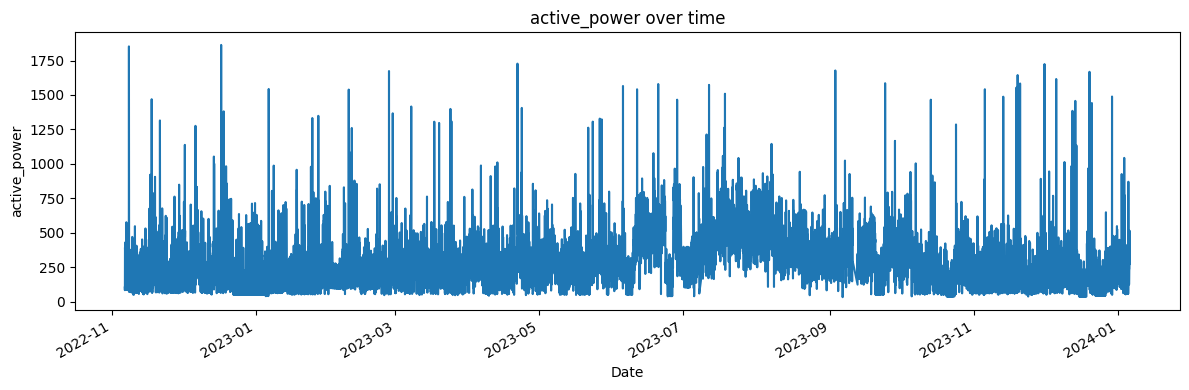

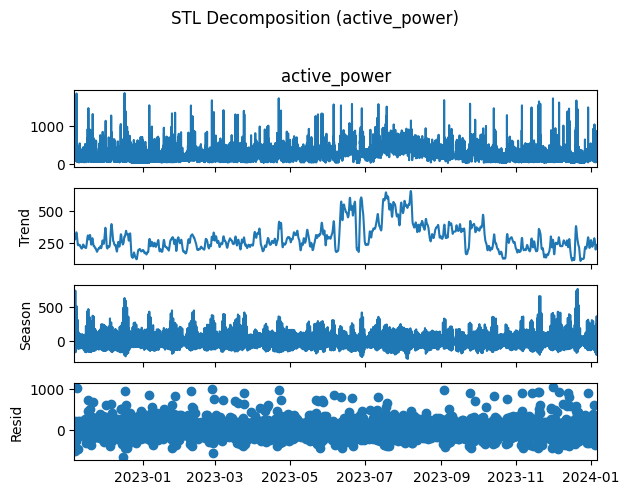

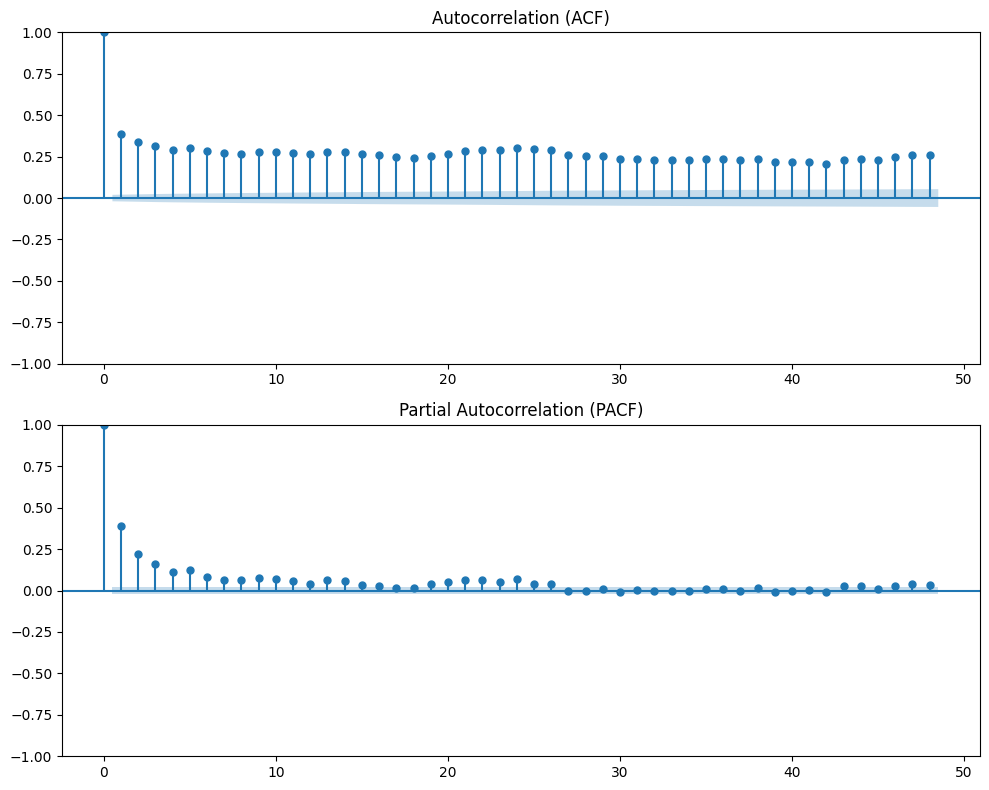

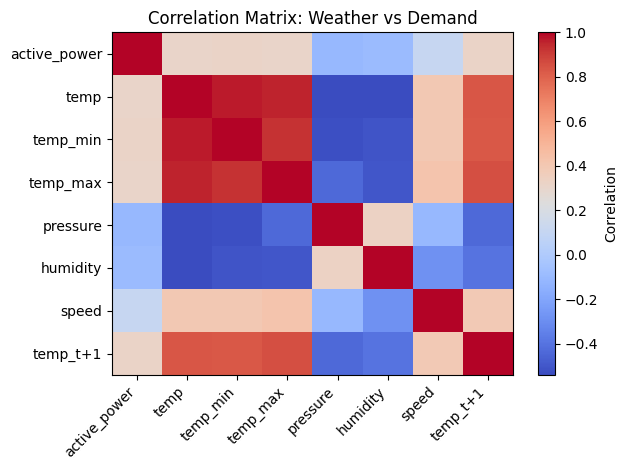

In [5]:
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import STL
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

EDA_START = None      # e.g. "2022-01-01"
EDA_END   = None      # e.g. "2022-03-31"
EDA_LAGS  = 48
EDA_STL_PERIOD = 24

print("\n===== DATA SHAPE =====")
print(df.shape)

print("\n===== MISSING VALUES (top 20) =====")
print(df.isna().sum().sort_values(ascending=False).head(20))

print("\n===== DESCRIPTIVE STATS (target) =====")
print(df[TARGET_COLUMN].describe())

# Time series plot
plt.figure(figsize=(12, 4))
df[TARGET_COLUMN].loc[EDA_START:EDA_END].plot()
plt.title(f"{TARGET_COLUMN} over time"); plt.xlabel("Date"); plt.ylabel(TARGET_COLUMN)
plt.tight_layout(); plt.show()

# STL decomposition
try:
    series = df[TARGET_COLUMN].dropna()
    if len(series) >= 2 * EDA_STL_PERIOD:
        res = STL(series, period=EDA_STL_PERIOD).fit()
        res.plot()
        plt.suptitle(f"STL Decomposition ({TARGET_COLUMN})", y=1.02)
        plt.tight_layout(); plt.show()
    else:
        print(f"[INFO] Not enough data for STL (need >= {2*EDA_STL_PERIOD} points).")
except Exception as e:
    print(f"[WARN] STL decomposition skipped: {e}")

# ACF / PACF
try:
    fig, axes = plt.subplots(2, 1, figsize=(10, 8))
    plot_acf(df[TARGET_COLUMN].dropna(), ax=axes[0], lags=EDA_LAGS)
    plot_pacf(df[TARGET_COLUMN].dropna(), ax=axes[1], lags=EDA_LAGS)
    axes[0].set_title("Autocorrelation (ACF)")
    axes[1].set_title("Partial Autocorrelation (PACF)")
    plt.tight_layout(); plt.show()
except Exception as e:
    print(f"[WARN] ACF/PACF skipped: {e}")

# Weather vs. target correlation heatmap
import pandas as pd
weather_prefixes = ("temp", "humidity", "pressure", "speed")
cand_weather = [c for c in df.columns if any(c.startswith(p) for p in weather_prefixes)]
weather_cols = [c for c in cand_weather if pd.api.types.is_numeric_dtype(df[c])]

if weather_cols:
    cols = [TARGET_COLUMN] + weather_cols
    corr = df[cols].corr()
    plt.figure(figsize=(max(6, len(cols)*0.8), max(4, len(cols)*0.6)))
    plt.imshow(corr, cmap="coolwarm", aspect="auto")
    plt.xticks(range(len(cols)), cols, rotation=45, ha="right")
    plt.yticks(range(len(cols)), cols)
    plt.colorbar(label="Correlation")
    plt.title("Correlation Matrix: Weather vs Demand")
    plt.tight_layout(); plt.show()
else:
    print("[INFO] No numeric weather columns found with prefixes:", weather_prefixes)

## 6) Metrics helpers (used by models)

In [13]:
import numpy as np
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

def evaluate(y_true, y_pred, prefix: str = ""):
    y_true = np.asarray(y_true).ravel()
    y_pred = np.asarray(y_pred).ravel()
    mae = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100
    r2 = r2_score(y_true, y_pred)
    metrics = {f"{prefix}MAE": mae, f"{prefix}RMSE": rmse, f"{prefix}MAPE": mape, f"{prefix}R2": r2}
    for k, v in metrics.items(): print(f"{k}: {v:.4f}")
    #return metrics

## 7) Feature Prep for Models (runs immediately)

In [7]:
import numpy as np
import pandas as pd

df_model = df.copy()

# One-hot for weather description if present
if "description" in df_model.columns:
    df_model["weather_desc"] = df_model["description"].astype("category")
    df_model = pd.get_dummies(df_model, columns=["weather_desc"], drop_first=True)

# Add columns used by TFT (safe to add even if you won't use TFT)
df_model["time_idx"] = np.arange(len(df_model))
df_model["all"] = 0

# Recompute split based on the engineered df_model (same length as df)
n_total = len(df_model)
n_test = int(n_total * TEST_FRACTION)
n_val  = int(n_total * VAL_FRACTION)
train_df = df_model.iloc[: -(n_val + n_test)]
val_df   = df_model.iloc[-(n_val + n_test) : -n_test]
test_df  = df_model.iloc[-n_test :]

# Identify categorical (one-hot) and numeric features
cat_features = [c for c in df_model.columns if c.startswith("weather_desc_")]
num_features = df_model.select_dtypes(include="number").columns.difference(cat_features + ["time_idx","all", TARGET_COLUMN])
feature_cols = num_features.tolist() + cat_features

print("✓ Model features prepared.")
print("Feature count:", len(feature_cols), "| cat:", len(cat_features), "| num:", len(num_features))
print("Target:", TARGET_COLUMN)
print("Train/Val/Test sizes:", len(train_df), len(val_df), len(test_df))

✓ Model features prepared.
Feature count: 59 | cat: 13 | num: 46
Target: active_power
Train/Val/Test sizes: 7042 1005 2011


## 8) Random Forest — Train & Evaluate (runs immediately)

In [9]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import RandomizedSearchCV, TimeSeriesSplit
from scipy.stats import randint
import pandas as pd
import joblib

# Build pipeline
pre = ColumnTransformer([
    ("num", StandardScaler(), [c for c in feature_cols if c in num_features]),
    ("cat", OneHotEncoder(handle_unknown="ignore"), [c for c in feature_cols if c in cat_features]),
])
rf = RandomForestRegressor(n_estimators=400, random_state=42, n_jobs=-1)
rf_pipe = Pipeline([("pre", pre), ("model", rf)])

# ---- RandomizedSearchCV (added) ----
param_dist = {
    "model__n_estimators": [200, 400, 600, 800],
    "model__max_depth": [None, 10, 20, 30, 40],
    "model__min_samples_leaf": [1, 2, 4],
    "model__max_features": ["sqrt", None, 0.5, 0.8],
    "model__bootstrap": [True, False],
}
tscv = TimeSeriesSplit(n_splits=5)

search = RandomizedSearchCV(
    estimator=rf_pipe,
    param_distributions=param_dist,
    n_iter=25,
    scoring="neg_mean_absolute_error",
    cv=tscv,
    n_jobs=-1,
    random_state=42,
    verbose=2,
    refit=True,  # refit best on full training set
)

# Train with randomized search
search.fit(train_df[feature_cols], train_df[TARGET_COLUMN])

# Save CV results to CSV
(MODEL_DIR / "tuning").mkdir(parents=True, exist_ok=True)
cv_df = pd.DataFrame(search.cv_results_).sort_values("rank_test_score")
cv_df.to_csv(MODEL_DIR / "tuning" / "rf_randomizedsearch_results.csv", index=False)

# Use best pipeline from search for the rest (keeps your original flow)
rf_pipe = search.best_estimator_

# Save
joblib.dump(rf_pipe, MODEL_DIR / "rf_model.joblib")

# Evaluate on validation and test (unchanged)
# Evaluate (prints)
print("Validation metrics:")
evaluate(val_df[TARGET_COLUMN], rf_pipe.predict(val_df[feature_cols]), prefix="rf_val_")

print("\nTest metrics:")
evaluate(test_df[TARGET_COLUMN], rf_pipe.predict(test_df[feature_cols]), prefix="rf_test_")



#print("Validation metrics:")
#val_m = evaluate(val_df[TARGET_COLUMN], rf_pipe.predict(val_df[feature_cols]), prefix="rf_val_")
#for k, v in val_m.items(): print(f"{k}: {v:.4f}")

#print("\nTest metrics:")
#test_m = evaluate(test_df[TARGET_COLUMN], rf_pipe.predict(test_df[feature_cols]), prefix="rf_test_")
#for k, v in test_m.items(): print(f"{k}: {v:.4f}")



Fitting 5 folds for each of 1 candidates, totalling 5 fits
Validation metrics:
rf_val_MAE: 23.0054
rf_val_RMSE: 46.5060
rf_val_MAPE: 9.7891
rf_val_R2: 0.9258

Test metrics:
rf_test_MAE: 21.6945
rf_test_RMSE: 54.7494
rf_test_MAPE: 13.2597
rf_test_R2: 0.9041


{'rf_test_MAE': 21.694489601491014,
 'rf_test_RMSE': 54.74936208237814,
 'rf_test_MAPE': 13.259681202820886,
 'rf_test_R2': 0.9040918713734579}

## 9) Extra Trees — Train & Evaluate (runs immediately)

In [10]:
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.model_selection import RandomizedSearchCV, TimeSeriesSplit
from scipy.stats import randint
import pandas as pd
import joblib

# Base pipeline (uses existing `pre`)
et = ExtraTreesRegressor(n_estimators=400, random_state=42, n_jobs=-1)
et_pipe = Pipeline([("pre", pre), ("model", et)])

# ---- RandomizedSearchCV ----
param_dist = {
    "model__n_estimators": [200, 400, 600, 800],
    "model__max_depth": [None, 10, 20, 30, 40],
    "model__min_samples_leaf": [1, 2, 4],
    "model__max_features": ["sqrt", None, 0.5, 0.8],
    "model__bootstrap": [False],  # ET typically doesn't bootstrap
}
tscv = TimeSeriesSplit(n_splits=5)

search = RandomizedSearchCV(
    estimator=et_pipe,
    param_distributions=param_dist,
    n_iter=25,
    scoring="neg_mean_absolute_error",
    cv=tscv,
    n_jobs=-1,
    random_state=42,
    verbose=2,
    refit=True,  # refit best on full training set
)

# Train with randomized search
search.fit(train_df[feature_cols], train_df[TARGET_COLUMN])

# Save CV results to CSV
(MODEL_DIR / "tuning").mkdir(parents=True, exist_ok=True)
cv_df = pd.DataFrame(search.cv_results_).sort_values("rank_test_score")
cv_df.to_csv(MODEL_DIR / "tuning" / "et_randomizedsearch_results.csv", index=False)

# Use best pipeline from search
et_pipe = search.best_estimator_

# Save final model
joblib.dump(et_pipe, MODEL_DIR / "et_model.joblib")

# Evaluate (prints)
try:
    print_metrics
except NameError:
    def print_metrics(m): 
        for k, v in m.items(): 
            print(f"{k}: {v:.4f}")

print("Validation metrics:")
evaluate(val_df[TARGET_COLUMN], rf_pipe.predict(val_df[feature_cols]), prefix="et_val_")

print("\nTest metrics:")
evaluate(test_df[TARGET_COLUMN], rf_pipe.predict(test_df[feature_cols]), prefix="et_test_")

#print("Validation metrics:")
#print_metrics(evaluate(val_df[TARGET_COLUMN], et_pipe.predict(val_df[feature_cols]), prefix="et_val_"))

#print("\nTest metrics:")
#print_metrics(evaluate(test_df[TARGET_COLUMN], et_pipe.predict(test_df[feature_cols]), prefix="et_test_"))


Fitting 5 folds for each of 25 candidates, totalling 125 fits


KeyboardInterrupt: 

## 10)LSTM — Train & Evaluate (toggle RUN_LSTM=True to execute)

In [15]:
# === LSTM — Immediate Execution (no def/class): Train, Save, Validate, Test ===
from pathlib import Path
import numpy as np, pandas as pd
import torch
from torch import nn
from torch.utils.data import TensorDataset, DataLoader
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# ---- sanity ----
for g in ("train_df","val_df","test_df","feature_cols"):
    if g not in globals():
        raise RuntimeError(f"Missing global: {g}. Run earlier cells first.")

TARGET_COLUMN     = str(globals().get("TARGET_COLUMN", "active_power"))
LAG_STEPS         = int(globals().get("LAG_STEPS", 24))
FORECAST_HORIZON  = int(globals().get("FORECAST_HORIZON", 1))
MODEL_DIR         = Path(globals().get("MODEL_DIR", Path.cwd() / "models")); MODEL_DIR.mkdir(parents=True, exist_ok=True)

# Config 
_lstm_units      = int(globals().get("LSTM_UNITS", 64))
_lstm_dense      = int(globals().get("LSTM_DENSE", 32))
_lstm_epochs     = int(globals().get("LSTM_EPOCHS", 50))     # increase for accuracy
_lstm_patience   = int(globals().get("LSTM_PATIENCE", 5))
_lstm_batch_size = int(globals().get("LSTM_BATCH_SIZE", 64))
_lr              = float(globals().get("LSTM_LR", 1e-3))

# ---- build sliding windows (train/val/test) ----
def _make_windows(df):
    blk = df[feature_cols + [TARGET_COLUMN]].values
    n = len(blk) - LAG_STEPS - FORECAST_HORIZON + 1
    if n <= 0: return np.empty((0, LAG_STEPS, len(feature_cols)), np.float32), np.empty((0,), np.float32)
    X = np.stack([blk[i:i+LAG_STEPS, :-1] for i in range(n)]).astype(np.float32)
    y = np.array([blk[i+LAG_STEPS+FORECAST_HORIZON-1, -1] for i in range(n)], dtype=np.float32)
    return X, y

X_tr, y_tr = _make_windows(train_df)
X_va, y_va = _make_windows(val_df)
X_te, y_te = _make_windows(test_df)

if len(X_tr) == 0:
    raise RuntimeError("Training windows are empty. Reduce LAG_STEPS or check data length.")

# ---- DataLoaders ----
train_dl = DataLoader(TensorDataset(torch.from_numpy(X_tr), torch.from_numpy(y_tr)), batch_size=_lstm_batch_size, shuffle=False)
val_dl   = DataLoader(TensorDataset(torch.from_numpy(X_va), torch.from_numpy(y_va)), batch_size=_lstm_batch_size, shuffle=False)
test_dl  = DataLoader(TensorDataset(torch.from_numpy(X_te), torch.from_numpy(y_te)), batch_size=_lstm_batch_size, shuffle=False)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# ---- model (no class): layers + forward inline ----
n_features = X_tr.shape[-1]
lstm = nn.LSTM(input_size=n_features, hidden_size=_lstm_units, batch_first=True).to(device)
fc1  = nn.Linear(_lstm_units, _lstm_dense).to(device)
relu = nn.ReLU().to(device)
out  = nn.Linear(_lstm_dense, 1).to(device)

optimizer = torch.optim.Adam(list(lstm.parameters()) + list(fc1.parameters()) + list(out.parameters()), lr=_lr)
loss_fn = nn.L1Loss()

# ---- train with simple early stopping ----
best_val = float("inf")
epochs_no_improve = 0
best_state = None

print("Training LSTM...")
for epoch in range(1, _lstm_epochs + 1):
    lstm.train(); fc1.train(); out.train()
    epoch_loss = 0.0
    for xb, yb in train_dl:
        xb = xb.to(device); yb = yb.to(device)
        optimizer.zero_grad()
        seq, _ = lstm(xb)
        last = seq[:, -1, :]
        preds = out(relu(fc1(last))).squeeze(1)
        loss = loss_fn(preds, yb)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item() * len(xb)
    epoch_loss /= len(train_dl.dataset)

    # validation
    lstm.eval(); fc1.eval(); out.eval()
    with torch.no_grad():
        vpreds = []
        for xb, _ in val_dl:
            xb = xb.to(device)
            seq, _ = lstm(xb)
            last = seq[:, -1, :]
            vpreds.append(out(relu(fc1(last))).squeeze(1).cpu())
        vpreds = torch.cat(vpreds).numpy().ravel() if len(vpreds) else np.array([])
    val_mae = mean_absolute_error(y_va, vpreds) if len(vpreds) else np.nan

    print(f"Epoch {epoch:02d} | train_mae ~ {epoch_loss:.4f} | val_mae = {val_mae:.4f}")

    # early stopping on val MAE
    if val_mae < best_val:
        best_val = val_mae
        epochs_no_improve = 0
        best_state = {
            "lstm": lstm.state_dict(),
            "fc1": fc1.state_dict(),
            "out": out.state_dict(),
        }
    else:
        epochs_no_improve += 1
        if epochs_no_improve >= _lstm_patience:
            print("Early stopping.")
            break

# restore best weights (if captured)
if best_state is not None:
    lstm.load_state_dict(best_state["lstm"])
    fc1.load_state_dict(best_state["fc1"])
    out.load_state_dict(best_state["out"])

# ---- save checkpoint compatible with your XAI cell ----
ckpt = {}
for name, module in (("lstm", lstm), ("fc1", fc1), ("out", out)):
    for k, v in module.state_dict().items():
        ckpt[f"{name}.{k}"] = v
torch.save({"state_dict": ckpt}, MODEL_DIR / "lstm_pl.ckpt")
print("✓ Saved checkpoint to", MODEL_DIR / "lstm_pl.ckpt")

# ---- final validation & test metrics (printed immediately) ----
def _metrics(y_true, y_pred, label):
    mae  = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mape = float(np.mean(np.abs((y_true - y_pred) / y_true)) * 100)
    r2   = r2_score(y_true, y_pred)
    print(f"{label}MAE:  {mae:.4f}\n{label}RMSE: {rmse:.4f}\n{label}MAPE:{mape:.2f}%\n{label}R2:  {r2:.4f}")

from sklearn.metrics import mean_squared_error

# Validation (already computed vpreds, but recompute cleanly)
lstm.eval(); fc1.eval(); out.eval()
with torch.no_grad():
    vpreds = []
    for xb, _ in val_dl:
        xb = xb.to(device)
        seq, _ = lstm(xb)
        last = seq[:, -1, :]
        vpreds.append(out(relu(fc1(last))).squeeze(1).cpu())
    vpreds = torch.cat(vpreds).numpy().ravel() if len(vpreds) else np.array([])

_metrics(y_va, vpreds, "lstm_val_")

# Test
with torch.no_grad():
    tpreds = []
    for xb, _ in test_dl:
        xb = xb.to(device)
        seq, _ = lstm(xb)
        last = seq[:, -1, :]
        tpreds.append(out(relu(fc1(last))).squeeze(1).cpu())
    tpreds = torch.cat(tpreds).numpy().ravel() if len(tpreds) else np.array([])

_metrics(y_te, tpreds, "lstm_test_")


d:\SEM_3_SETU\codes\project-shon\C00313480_power_consumption\C00313480_power_consumption\.venv\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Training LSTM...
Epoch 01 | train_mae ~ 290.1804 | val_mae = 284.7961
Epoch 02 | train_mae ~ 221.3185 | val_mae = 188.0296
Epoch 03 | train_mae ~ 146.0608 | val_mae = 132.6432
Epoch 04 | train_mae ~ 136.9734 | val_mae = 128.5927
Epoch 05 | train_mae ~ 137.7545 | val_mae = 128.2026
Epoch 06 | train_mae ~ 136.4924 | val_mae = 126.9788
Epoch 07 | train_mae ~ 137.3173 | val_mae = 126.8853
Epoch 08 | train_mae ~ 137.3523 | val_mae = 127.2069
Epoch 09 | train_mae ~ 137.3833 | val_mae = 127.0036
Epoch 10 | train_mae ~ 137.2575 | val_mae = 127.3338
Epoch 11 | train_mae ~ 136.6511 | val_mae = 126.5614
Epoch 12 | train_mae ~ 137.5507 | val_mae = 126.6901
Epoch 13 | train_mae ~ 137.2201 | val_mae = 126.5630
Epoch 14 | train_mae ~ 136.5934 | val_mae = 126.3647
Epoch 15 | train_mae ~ 136.8835 | val_mae = 126.2345
Epoch 16 | train_mae ~ 136.4683 | val_mae = 126.1505
Epoch 17 | train_mae ~ 136.3907 | val_mae = 125.9904
Epoch 18 | train_mae ~ 136.4847 | val_mae = 125.8530
Epoch 19 | train_mae ~ 135.95

# TFT

In [ ]:
# === TFT — Immediate Execution: Train (best ckpt), Save, Val & Test Metrics ===
# Requires: train_df, val_df, test_df, feature_cols, and columns ["time_idx", "all"] present.

from pathlib import Path
import numpy as np
import pandas as pd
import pytorch_lightning as pl

# ---- sanity checks / defaults ----
for name in ("train_df","val_df","test_df","feature_cols"):
    if name not in globals():
        raise RuntimeError(f"{name} not found. Run earlier cells to prepare data & features.")
for col in ("time_idx","all"):
    if col not in train_df.columns:
        raise RuntimeError(f"Column '{col}' missing. Ensure your feature-prep cell added time_idx/all columns.")

TARGET_COLUMN     = str(globals().get("TARGET_COLUMN", "active_power"))
LAG_STEPS         = int(globals().get("LAG_STEPS", 24))
FORECAST_HORIZON  = int(globals().get("FORECAST_HORIZON", 1))
MODEL_DIR         = globals().get("MODEL_DIR", Path.cwd() / "models")
MODEL_DIR.mkdir(parents=True, exist_ok=True)

# Config (use global TFT_CONFIG if available; else fallback)
TFT_CONFIG = dict(globals().get("TFT_CONFIG", {
    "hidden_size": 64,
    "attention_head_size": 4,
    "dropout": 0.1,
    "hidden_continuous_size": 32,
    "learning_rate": 1e-3,
    "max_epochs": 50,    # keep modest for a quick run; increase for accuracy
    "batch_size": 64,
}))

# ---- dependencies ----
try:
    import pytorch_forecasting as ptf
except Exception as e:
    raise ImportError(
        "pytorch-forecasting is required for TFT. Install it first, e.g.:\n"
        "!pip install pytorch-forecasting"
    ) from e

# ---- dataset creation ----
max_encoder_length     = LAG_STEPS
max_prediction_length  = FORECAST_HORIZON
time_varying_known_reals   = feature_cols
time_varying_unknown_reals = [TARGET_COLUMN]

training = ptf.TimeSeriesDataSet(
    train_df,
    time_idx="time_idx",
    target=TARGET_COLUMN,
    group_ids=["all"],
    max_encoder_length=max_encoder_length,
    max_prediction_length=max_prediction_length,
    time_varying_known_reals=time_varying_known_reals,
    time_varying_unknown_reals=time_varying_unknown_reals,
)
validation = ptf.TimeSeriesDataSet.from_dataset(training, val_df, stop_randomization=True)

train_dl = training.to_dataloader(train=True,  batch_size=TFT_CONFIG["batch_size"])
val_dl   = validation.to_dataloader(train=False, batch_size=TFT_CONFIG["batch_size"])

# ---- model ----
tft = ptf.TemporalFusionTransformer.from_dataset(
    training,
    learning_rate=TFT_CONFIG["learning_rate"],
    hidden_size=TFT_CONFIG["hidden_size"],
    attention_head_size=TFT_CONFIG["attention_head_size"],
    dropout=TFT_CONFIG["dropout"],
    hidden_continuous_size=TFT_CONFIG["hidden_continuous_size"],
    loss=ptf.metrics.MAE(),
    log_interval=10,
)

# ---- training with best-ckpt tracking & early stopping ----
ckpt_cb = pl.callbacks.ModelCheckpoint(
    monitor="val_loss", mode="min", save_top_k=1, filename="tft-best"
)
es_cb = pl.callbacks.EarlyStopping(monitor="val_loss", mode="min", patience=3)

trainer = pl.Trainer(
    max_epochs=TFT_CONFIG["max_epochs"],
    accelerator="auto",
    callbacks=[ckpt_cb, es_cb],
    enable_progress_bar=True,
    deterministic=True,
)

print("Training TFT...")
trainer.fit(tft, train_dl, val_dl)
best_ckpt = ckpt_cb.best_model_path or (MODEL_DIR / "tft.ckpt")
if not best_ckpt:
    # fall back to saving current model if callback wasn't populated for some reason
    best_ckpt = str(MODEL_DIR / "tft.ckpt")
    trainer.save_checkpoint(best_ckpt)
print("Best checkpoint:", best_ckpt)

# Save a copy to the models folder if not already there
if not str(best_ckpt).startswith(str(MODEL_DIR)):
    # copy weights into models dir
    import shutil
    dst = MODEL_DIR / Path(best_ckpt).name
    shutil.copy2(best_ckpt, dst)
    best_ckpt = str(dst)

# Load the best model for evaluation
tft_best = ptf.TemporalFusionTransformer.load_from_checkpoint(best_ckpt)

# ---- evaluate on VALIDATION ----
val_preds = tft_best.predict(val_dl).detach().cpu().numpy().ravel()
y_val = np.concatenate([y[0].cpu().numpy().ravel() for _, y in val_dl])

# Fallback metrics if not defined globally
try:
    evaluate  # type: ignore
    print_metrics  # type: ignore
except NameError:
    from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
    def evaluate(y_true, y_pred, prefix=""):
        y_true = np.asarray(y_true).ravel()
        y_pred = np.asarray(y_pred).ravel()
        mae = mean_absolute_error(y_true, y_pred)
        rmse = np.sqrt(mean_squared_error(y_true, y_pred))
        mape = float(np.mean(np.abs((y_true - y_pred) / y_true)) * 100)
        r2 = r2_score(y_true, y_pred)
        return {f"{prefix}MAE": mae, f"{prefix}RMSE": rmse, f"{prefix}MAPE": mape, f"{prefix}R2": r2}
    def print_metrics(m): 
        for k, v in m.items(): 
            print(f"{k}: {v:.4f}")

val_metrics = evaluate(y_val, val_preds, prefix="tft_val_")
print("TFT Validation Metrics:")
print_metrics(val_metrics)

# ---- evaluate on TEST ----
test_ds = ptf.TimeSeriesDataSet.from_dataset(training, test_df, stop_randomization=True)
test_dl = test_ds.to_dataloader(train=False, batch_size=TFT_CONFIG["batch_size"])
test_preds = tft_best.predict(test_dl).detach().cpu().numpy().ravel()
y_test = np.concatenate([y[0].cpu().numpy().ravel() for _, y in test_dl])

test_metrics = evaluate(y_test, test_preds, prefix="tft_test_")
print("\nTFT Test Metrics:")
print_metrics(test_metrics)


d:\SEM_3_SETU\codes\project-shon\C00313480_power_consumption\C00313480_power_consumption\.venv\lib\site-packages\pytorch_lightning\utilities\parsing.py:261: UserWarning: Attribute 'loss' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss'])`.
  rank_zero_warn(
d:\SEM_3_SETU\codes\project-shon\C00313480_power_consumption\C00313480_power_consumption\.venv\lib\site-packages\pytorch_lightning\utilities\parsing.py:261: UserWarning: Attribute 'logging_metrics' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['logging_metrics'])`.
  rank_zero_warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

   | Name                               | Type                            | Params
---------------------

Training TFT...
Sanity Checking: 0it [00:00, ?it/s]

d:\SEM_3_SETU\codes\project-shon\C00313480_power_consumption\C00313480_power_consumption\.venv\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:240: PossibleUserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


d:\SEM_3_SETU\codes\project-shon\C00313480_power_consumption\C00313480_power_consumption\.venv\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:240: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Epoch 0: 100%|██████████| 125/125 [01:22<00:00,  1.52it/s, loss=65.1, v_num=44, train_loss_step=76.40, val_loss=68.10, train_loss_epoch=92.20]
Best checkpoint: d:\SEM_3_SETU\codes\project-shon\C00313480_power_consumption\C00313480_power_consumption\lightning_logs\version_44\checkpoints\tft-best.ckpt
tft_val_MAE: 68.1169
tft_val_RMSE: 103.3314
tft_val_MAPE: 32.7748
tft_val_R2: 0.6388
TFT Validation Metrics:
tft_val_MAE: 68.1169
tft_val_RMSE: 103.3314
tft_val_MAPE: 32.7748
tft_val_R2: 0.6388
tft_test_MAE: 70.1335
tft_test_RMSE: 115.5754
tft_test_MAPE: 48.0259
tft_test_R2: 0.5725

TFT Test Metrics:
tft_test_MAE: 70.1335
tft_test_RMSE: 115.5754
tft_test_MAPE: 48.0259
tft_test_R2: 0.5725


# optuna

In [ ]:
# === Optuna — Immediate Execution: RF / ET hyperparameter search, save, validate & test ===
# Runs as-is (no functions). Toggle RUN_OPT_* and adjust *TRIALS if needed.

RUN_OPT_RF = True
RUN_OPT_ET = True
OPT_RF_TRIALS = 2 #25
OPT_ET_TRIALS = 2  #25
RANDOM_STATE = int(globals().get("RANDOM_STATE", 42))

# ----- sanity checks -----
needed = ["train_df","val_df","test_df","feature_cols","MODEL_DIR","TARGET_COLUMN"]
missing = [n for n in needed if n not in globals()]
if missing:
    raise RuntimeError(f"Missing globals: {missing}. Run earlier cells (feature prep & split).")

import numpy as np, pandas as pd, joblib, optuna
from pathlib import Path
from sklearn.model_selection import TimeSeriesSplit
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor

MODEL_DIR = Path(MODEL_DIR); MODEL_DIR.mkdir(parents=True, exist_ok=True)
TARGET_COLUMN = str(TARGET_COLUMN)

# Fallback metrics if not defined earlier
try:
    evaluate  # type: ignore
    print_metrics  # type: ignore
except NameError:
    from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
    def evaluate(y_true, y_pred, prefix=""):
        y_true = np.asarray(y_true).ravel(); y_pred = np.asarray(y_pred).ravel()
        mae = mean_absolute_error(y_true, y_pred)
        rmse = np.sqrt(mean_squared_error(y_true, y_pred))
        mape = float(np.mean(np.abs((y_true - y_pred) / y_true)) * 100)
        r2 = r2_score(y_true, y_pred)
        return {f"{prefix}MAE": mae, f"{prefix}RMSE": rmse, f"{prefix}MAPE": mape, f"{prefix}R2": r2}
    def print_metrics(m): 
        for k, v in m.items(): print(f"{k}: {v:.4f}")

# Identify categorical features robustly (keep your precomputed cat_features if present)
if "cat_features" not in globals():
    cat_features = [c for c in feature_cols if pd.api.types.is_object_dtype(train_df[c])]
num_features = [c for c in feature_cols if c not in cat_features]

def _preprocessor(cat_features, num_features):
    return ColumnTransformer([
        ("num", StandardScaler(), num_features),
        ("cat", OneHotEncoder(handle_unknown="ignore"), cat_features),
    ])

# -------------------------- Random Forest optimisation --------------------------
if RUN_OPT_RF:
    print("\n[Optuna] Random Forest optimisation...")
    def rf_objective(trial):
        params = {
            "n_estimators": trial.suggest_int("n_estimators", 200, 800),
            "max_depth": trial.suggest_int("max_depth", 5, 40, log=True),
            "min_samples_leaf": trial.suggest_int("min_samples_leaf", 1, 10),
        }
        model = RandomForestRegressor(random_state=RANDOM_STATE, n_jobs=-1, **params)
        pipe  = Pipeline([("pre", _preprocessor(cat_features, num_features)), ("model", model)])
        ts_cv = TimeSeriesSplit(n_splits=3)
        maes = []
        for tr_idx, va_idx in ts_cv.split(train_df):
            X_tr, X_va = train_df.iloc[tr_idx][feature_cols], train_df.iloc[va_idx][feature_cols]
            y_tr, y_va = train_df.iloc[tr_idx][TARGET_COLUMN], train_df.iloc[va_idx][TARGET_COLUMN]
            pipe.fit(X_tr, y_tr)
            pred = pipe.predict(X_va)
            maes.append(np.mean(np.abs(pred - y_va)))
        return float(np.mean(maes))

    study_rf = optuna.create_study(direction="minimize", sampler=optuna.samplers.TPESampler(seed=RANDOM_STATE))
    study_rf.optimize(rf_objective, n_trials=OPT_RF_TRIALS)
    print("Best RF params:", study_rf.best_params)

    rf_best = RandomForestRegressor(random_state=RANDOM_STATE, n_jobs=-1, **study_rf.best_params)
    rf_pipe = Pipeline([("pre", _preprocessor(cat_features, num_features)), ("model", rf_best)])
    rf_pipe.fit(train_df[feature_cols], train_df[TARGET_COLUMN])
    joblib.dump(rf_pipe, MODEL_DIR / "opt_rf_model.joblib")

    # validate & test
    rf_val_pred  = rf_pipe.predict(val_df[feature_cols])
    rf_val_metrics = evaluate(val_df[TARGET_COLUMN], rf_val_pred, prefix="opt_rf_val_"); print_metrics(rf_val_metrics)
    rf_test_pred = rf_pipe.predict(test_df[feature_cols])
    rf_test_metrics = evaluate(test_df[TARGET_COLUMN], rf_test_pred, prefix="opt_rf_test_"); print_metrics(rf_test_metrics)
else:
    print("\n[Optuna] Skipping Random Forest (set RUN_OPT_RF=True to run).")

# -------------------------- Extra Trees optimisation ---------------------------
if RUN_OPT_ET:
    print("\n[Optuna] Extra Trees optimisation...")
    def et_objective(trial):
        params = {
            "n_estimators": trial.suggest_int("n_estimators", 200, 800),
            "max_depth": trial.suggest_int("max_depth", 5, 40, log=True),
            "min_samples_leaf": trial.suggest_int("min_samples_leaf", 1, 10),
        }
        model = ExtraTreesRegressor(random_state=RANDOM_STATE, n_jobs=-1, **params)
        pipe  = Pipeline([("pre", _preprocessor(cat_features, num_features)), ("model", model)])
        ts_cv = TimeSeriesSplit(n_splits=3)
        maes = []
        for tr_idx, va_idx in ts_cv.split(train_df):
            X_tr, X_va = train_df.iloc[tr_idx][feature_cols], train_df.iloc[va_idx][feature_cols]
            y_tr, y_va = train_df.iloc[tr_idx][TARGET_COLUMN], train_df.iloc[va_idx][TARGET_COLUMN]
            pipe.fit(X_tr, y_tr)
            pred = pipe.predict(X_va)
            maes.append(np.mean(np.abs(pred - y_va)))
        return float(np.mean(maes))

    study_et = optuna.create_study(direction="minimize", sampler=optuna.samplers.TPESampler(seed=RANDOM_STATE))
    study_et.optimize(et_objective, n_trials=OPT_ET_TRIALS)
    print("Best ET params:", study_et.best_params)

    et_best = ExtraTreesRegressor(random_state=RANDOM_STATE, n_jobs=-1, **study_et.best_params)
    et_pipe = Pipeline([("pre", _preprocessor(cat_features, num_features)), ("model", et_best)])
    et_pipe.fit(train_df[feature_cols], train_df[TARGET_COLUMN])
    joblib.dump(et_pipe, MODEL_DIR / "opt_et_model.joblib")

    # validate & test
    et_val_pred  = et_pipe.predict(val_df[feature_cols])
    et_val_metrics = evaluate(val_df[TARGET_COLUMN], et_val_pred, prefix="opt_et_val_"); print_metrics(et_val_metrics)
    et_test_pred = et_pipe.predict(test_df[feature_cols])
    et_test_metrics = evaluate(test_df[TARGET_COLUMN], et_test_pred, prefix="opt_et_test_"); print_metrics(et_test_metrics)
else:
    print("\n[Optuna] Skipping Extra Trees (set RUN_OPT_ET=True to run).")

print("\n✅ Optuna optimisation finished.")


[I 2025-08-17 20:22:28,914] A new study created in memory with name: no-name-37c3b1d3-0832-4a26-a20f-7dad0cf85e45



[Optuna] Random Forest optimisation...


[I 2025-08-17 20:22:38,931] Trial 0 finished with value: 4.862931722312678 and parameters: {'n_estimators': 425, 'max_depth': 36, 'min_samples_leaf': 8}. Best is trial 0 with value: 4.862931722312678.
[I 2025-08-17 20:22:49,283] Trial 1 finished with value: 7.51841897873194 and parameters: {'n_estimators': 559, 'max_depth': 6, 'min_samples_leaf': 2}. Best is trial 0 with value: 4.862931722312678.


Best RF params: {'n_estimators': 425, 'max_depth': 36, 'min_samples_leaf': 8}


[I 2025-08-17 20:22:57,137] A new study created in memory with name: no-name-f559f627-fb56-4bca-a487-c7eb47bec1fd


opt_rf_val_MAE: 2.9409
opt_rf_val_RMSE: 8.5191
opt_rf_val_MAPE: 1.0931
opt_rf_val_R2: 0.9975
opt_rf_val_MAE: 2.9409
opt_rf_val_RMSE: 8.5191
opt_rf_val_MAPE: 1.0931
opt_rf_val_R2: 0.9975
opt_rf_test_MAE: 3.2421
opt_rf_test_RMSE: 8.1106
opt_rf_test_MAPE: 2.0553
opt_rf_test_R2: 0.9979
opt_rf_test_MAE: 3.2421
opt_rf_test_RMSE: 8.1106
opt_rf_test_MAPE: 2.0553
opt_rf_test_R2: 0.9979

[Optuna] Extra Trees optimisation...


[I 2025-08-17 20:23:01,493] Trial 0 finished with value: 4.81921021622217 and parameters: {'n_estimators': 425, 'max_depth': 36, 'min_samples_leaf': 8}. Best is trial 0 with value: 4.81921021622217.
[I 2025-08-17 20:23:04,626] Trial 1 finished with value: 10.08739925660035 and parameters: {'n_estimators': 559, 'max_depth': 6, 'min_samples_leaf': 2}. Best is trial 0 with value: 4.81921021622217.


Best ET params: {'n_estimators': 425, 'max_depth': 36, 'min_samples_leaf': 8}
opt_et_val_MAE: 6.0304
opt_et_val_RMSE: 9.8761
opt_et_val_MAPE: 1.9621
opt_et_val_R2: 0.9967
opt_et_val_MAE: 6.0304
opt_et_val_RMSE: 9.8761
opt_et_val_MAPE: 1.9621
opt_et_val_R2: 0.9967
opt_et_test_MAE: 5.1059
opt_et_test_RMSE: 9.7133
opt_et_test_MAPE: 2.5668
opt_et_test_R2: 0.9970
opt_et_test_MAE: 5.1059
opt_et_test_RMSE: 9.7133
opt_et_test_MAPE: 2.5668
opt_et_test_R2: 0.9970

✅ Optuna optimisation finished.


## 11) (Optional) XAI — SHAP & Permutation Importance


=== XAI: Tree Models (SHAP + Permutation Importance) ===
→ RF: SHAP summary…


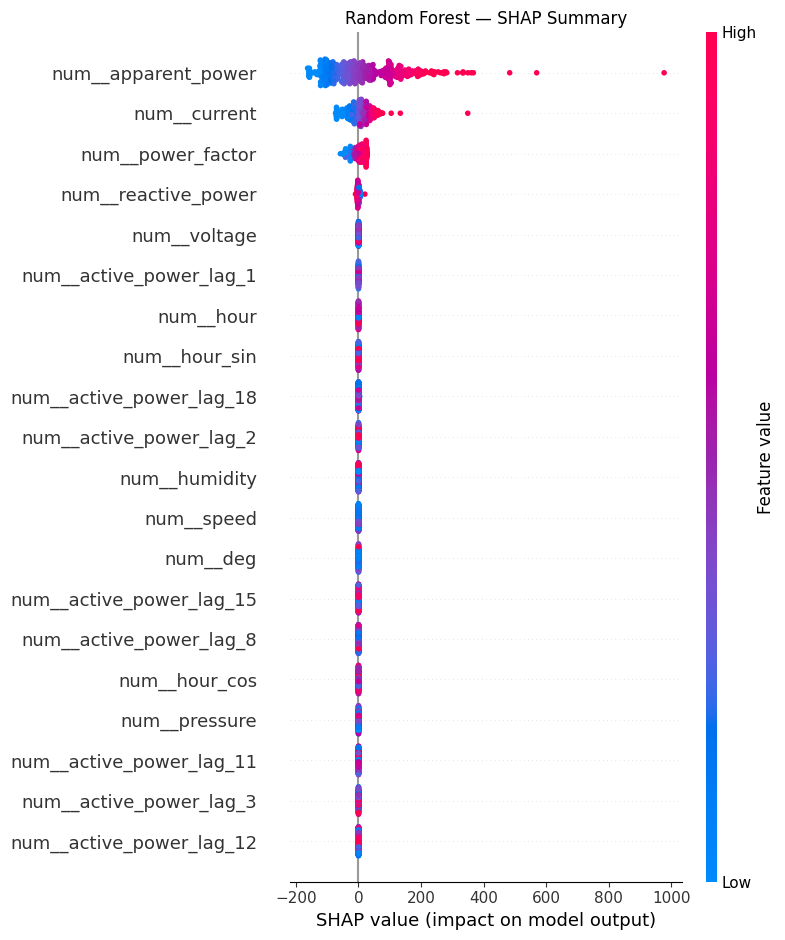

[OK] Saved d:\SEM_3_SETU\codes\project-shon\C00313480_power_consumption\C00313480_power_consumption\models\xai\rf_shap_summary.png
→ RF: Permutation importance…


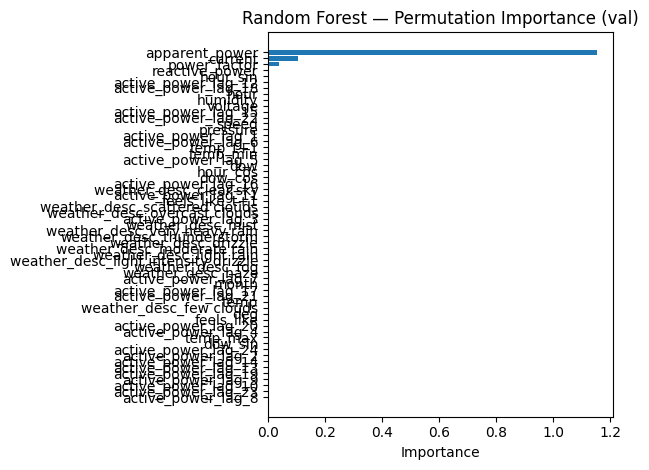

[OK] Saved d:\SEM_3_SETU\codes\project-shon\C00313480_power_consumption\C00313480_power_consumption\models\xai\rf_perm_importance.png
→ ET: SHAP summary…


In [ ]:
# ==== XAI — Immediate Execution (NO `def`) ====
# Explains: RF/ET (SHAP + permutation importance), LSTM (Kernel SHAP), TFT (VI + attention)
# Saves figures to models/xai/ and shows them inline.

import numpy as np, pandas as pd, matplotlib.pyplot as plt, os
from pathlib import Path

# ---- toggles ----
RUN_TREES_XAI = True
RUN_LSTM_XAI  = True
RUN_TFT_XAI   = True

# ---- globals & sanity ----
RANDOM_STATE = int(globals().get("RANDOM_STATE", 42))
MODEL_DIR    = Path(globals().get("MODEL_DIR", Path.cwd() / "models")); MODEL_DIR.mkdir(parents=True, exist_ok=True)
XAI_DIR      = MODEL_DIR / "xai"; XAI_DIR.mkdir(parents=True, exist_ok=True)

for n in ("val_df","feature_cols","TARGET_COLUMN"):
    if n not in globals():
        raise RuntimeError(f"Missing global: {n}. Run earlier cells first.")
TARGET_COLUMN = str(TARGET_COLUMN)
X_sample = val_df[feature_cols].iloc[: min(500, len(val_df))].copy()
y_val    = val_df[TARGET_COLUMN].iloc[: len(X_sample)]

# =========================================================================================
# 1) Trees (RF / ET): SHAP + Permutation Importance
# =========================================================================================
if RUN_TREES_XAI:
    print("\n=== XAI: Tree Models (SHAP + Permutation Importance) ===")
    import joblib
    try:
        from sklearn.inspection import permutation_importance
        import shap, scipy.sparse as sp
    except Exception as e:
        shap = None; sp = None
        print("[WARN] Install `shap` and `scipy` to enable tree SHAP:", e)

    # Random Forest
    _rf_pipeline = None
    if (MODEL_DIR / "rf_model.joblib").exists():
        _rf_pipeline = joblib.load(MODEL_DIR / "rf_model.joblib")
    elif "rf_pipe" in globals():
        _rf_pipeline = rf_pipe
    if _rf_pipeline is not None:
        pre = _rf_pipeline.named_steps.get("pre", None)
        model = _rf_pipeline.named_steps.get("model", None)
        if pre is not None and model is not None:
            X_proc = pre.transform(X_sample)
            if (sp is not None) and sp.issparse(X_proc): X_proc = X_proc.toarray()
            try: proc_names = pre.get_feature_names_out()
            except Exception: proc_names = feature_cols
            if shap is not None:
                print("→ RF: SHAP summary…")
                shap_vals = shap.TreeExplainer(model).shap_values(X_proc)
                shap.summary_plot(shap_vals, X_proc, feature_names=proc_names, show=False)
                plt.title("Random Forest — SHAP Summary"); plt.tight_layout()
                out = XAI_DIR / "rf_shap_summary.png"; plt.savefig(out, dpi=160); plt.show()
                print("[OK] Saved", out)
            print("→ RF: Permutation importance…")
            pi = permutation_importance(_rf_pipeline, X_sample, y_val, n_repeats=20, random_state=RANDOM_STATE, n_jobs=-1)
            order = np.argsort(pi.importances_mean)
            plt.barh(range(len(order)), pi.importances_mean[order])
            plt.yticks(range(len(order)), np.array(X_sample.columns)[order])
            plt.title("Random Forest — Permutation Importance (val)"); plt.xlabel("Importance")
            plt.tight_layout(); out = XAI_DIR / "rf_perm_importance.png"; plt.savefig(out, dpi=160); plt.show()
            print("[OK] Saved", out)
        else:
            print("[WARN] RF pipeline missing 'pre' or 'model' step.")
    else:
        print("[INFO] RF pipeline not found; skipping.")

    # Extra Trees
    _et_pipeline = None
    if (MODEL_DIR / "et_model.joblib").exists():
        _et_pipeline = joblib.load(MODEL_DIR / "et_model.joblib")
    elif "et_pipe" in globals():
        _et_pipeline = et_pipe
    if _et_pipeline is not None:
        pre = _et_pipeline.named_steps.get("pre", None)
        model = _et_pipeline.named_steps.get("model", None)
        if pre is not None and model is not None:
            X_proc = pre.transform(X_sample)
            if (sp is not None) and sp.issparse(X_proc): X_proc = X_proc.toarray()
            try: proc_names = pre.get_feature_names_out()
            except Exception: proc_names = feature_cols
            if shap is not None:
                print("→ ET: SHAP summary…")
                shap_vals = shap.TreeExplainer(model).shap_values(X_proc)
                shap.summary_plot(shap_vals, X_proc, feature_names=proc_names, show=False)
                plt.title("Extra Trees — SHAP Summary"); plt.tight_layout()
                out = XAI_DIR / "et_shap_summary.png"; plt.savefig(out, dpi=160); plt.show()
                print("[OK] Saved", out)
            print("→ ET: Permutation importance…")
            pi = permutation_importance(_et_pipeline, X_sample, y_val, n_repeats=20, random_state=RANDOM_STATE, n_jobs=-1)
            order = np.argsort(pi.importances_mean)
            plt.barh(range(len(order)), pi.importances_mean[order])
            plt.yticks(range(len(order)), np.array(X_sample.columns)[order])
            plt.title("Extra Trees — Permutation Importance (val)"); plt.xlabel("Importance")
            plt.tight_layout(); out = XAI_DIR / "et_perm_importance.png"; plt.savefig(out, dpi=160); plt.show()
            print("[OK] Saved", out)
        else:
            print("[WARN] ET pipeline missing 'pre' or 'model' step.")
    else:
        print("[INFO] ET pipeline not found; skipping.")
else:
    print("\n[INFO] Skipping Trees XAI (set RUN_TREES_XAI=True).")

# =========================================================================================
# 2) LSTM — Kernel SHAP (NO function defs; uses a lambda)
# =========================================================================================
if RUN_LSTM_XAI:
    print("\n=== XAI: LSTM (Kernel SHAP on validation windows) ===")
    import torch
    lstm_ckpt = MODEL_DIR / "lstm_pl.ckpt"
    if not lstm_ckpt.exists():
        print("[INFO] LSTM checkpoint not found; skipping LSTM XAI.")
    else:
        try:
            import shap
            state = torch.load(lstm_ckpt, map_location="cpu")["state_dict"]
            hid_size        = state["lstm.weight_hh_l0"].shape[1]
            dense_units     = state["fc1.weight"].shape[0]
            input_size_ckpt = state["lstm.weight_ih_l0"].shape[1]
            if input_size_ckpt != len(feature_cols):
                raise RuntimeError(f"Checkpoint expects {input_size_ckpt} features; feature_cols has {len(feature_cols)}.")

            from torch import nn
            lstm = nn.LSTM(input_size=input_size_ckpt, hidden_size=hid_size, batch_first=True)
            fc1  = nn.Linear(hid_size, dense_units)
            relu = nn.ReLU()
            out  = nn.Linear(dense_units, 1)

            # load weights into individual modules
            lstm.load_state_dict({k.split("lstm.")[1]: v for k,v in state.items() if k.startswith("lstm.")}, strict=False)
            fc1.load_state_dict ({k.split("fc1." )[1]: v for k,v in state.items() if k.startswith("fc1." )},  strict=False)
            out.load_state_dict ({k.split("out." )[1]: v for k,v in state.items() if k.startswith("out." )},  strict=False)
            for m in (lstm, fc1, out): m.eval()

            # build windows from validation
            LAG_STEPS = int(globals().get("LAG_STEPS", 24))
            blk = val_df[feature_cols + [TARGET_COLUMN]].copy()
            n_seq = len(blk) - LAG_STEPS
            if n_seq <= 0:
                raise RuntimeError("Not enough rows for LSTM windows; reduce LAG_STEPS or add data.")
            Xseq = np.stack([blk.iloc[i:i+LAG_STEPS, :-1].values.astype("float32") for i in range(n_seq)])

            bg_n = min(50, len(Xseq))
            ts_n = min(20, max(0, len(Xseq) - bg_n)) or min(10, len(Xseq))
            background = Xseq[:bg_n]
            test_data  = Xseq[bg_n:bg_n+ts_n] if len(Xseq) > bg_n else Xseq[:ts_n]

            # prediction lambda (no def)
            predict_fn = lambda x: (
                out(
                    relu(
                        fc1(
                            lstm(
                                torch.tensor(
                                    x.reshape((x.shape[0], LAG_STEPS, len(feature_cols))), dtype=torch.float32
                                )
                            )[0][:, -1, :]
                        )
                    )
                )
                .detach()
                .numpy()
                .ravel()
            )

            bg_flat = background.reshape(background.shape[0], -1)
            xs_flat = test_data.reshape(test_data.shape[0], -1)
            flat_names = [f"{feat}_t-{lag}" for lag in range(LAG_STEPS, 0, -1) for feat in feature_cols]

            expl = shap.KernelExplainer(predict_fn, bg_flat)
            shap_vals = expl.shap_values(xs_flat)
            shap.summary_plot(shap_vals, xs_flat, feature_names=flat_names, show=False)
            plt.title("LSTM — Kernel SHAP (validation slice)"); plt.tight_layout()
            out_path = XAI_DIR / "lstm_kernel_shap_summary.png"; plt.savefig(out_path, dpi=160); plt.show()
            print("[OK] Saved", out_path)
        except Exception as e:
            print("[WARN] LSTM SHAP skipped:", e)
else:
    print("\n[INFO] Skipping LSTM XAI (set RUN_LSTM_XAI=True).")

# =========================================================================================
# 3) TFT — Global Interpretation (Variable Importance + Attention)
# =========================================================================================
if RUN_TFT_XAI:
    print("\n=== XAI: TFT (variable importance & attention) ===")
    try:
        import pytorch_forecasting as ptf
        tft_ckpt = MODEL_DIR / "tft.ckpt"
        if not tft_ckpt.exists():
            print("[INFO] TFT checkpoint not found; skipping TFT XAI.")
        else:
            for n in ("train_df",):
                if n not in globals(): raise RuntimeError("train_df required to rebuild TFT dataset.")
            LAG_STEPS = int(globals().get("LAG_STEPS", 24))
            FORECAST_HORIZON = int(globals().get("FORECAST_HORIZON", 1))

            training = ptf.TimeSeriesDataSet(
                train_df,
                time_idx="time_idx",
                target=TARGET_COLUMN,
                group_ids=["all"],
                max_encoder_length=LAG_STEPS,
                max_prediction_length=FORECAST_HORIZON,
                time_varying_known_reals=feature_cols,
                time_varying_unknown_reals=[TARGET_COLUMN],
            )
            val_ds = ptf.TimeSeriesDataSet.from_dataset(training, val_df, stop_randomization=True)
            val_dl = val_ds.to_dataloader(train=False, batch_size=64)

            tft = ptf.TemporalFusionTransformer.load_from_checkpoint(tft_ckpt)
            raw, x = tft.predict(val_dl, mode="raw", return_x=True)
            try: interp = tft.interpret_output(raw, reduction=None)
            except Exception: interp = tft.interpret_output(raw, reduction="sum")

            # Decoder Variable Importance
            vi = interp.get("decoder_variables", None)
            if vi is not None:
                if isinstance(vi, dict):
                    names = list(vi.keys()); scores = [float(vi[n]) for n in names]
                else:
                    arr = vi.detach().cpu().numpy() if hasattr(vi, "detach") else np.array(vi)
                    scores = arr.mean(axis=0).tolist() if arr.ndim > 1 else arr.tolist()
                    names = feature_cols[: len(scores)]
                order = np.argsort(scores)[::-1]
                plt.barh([names[i] for i in order][::-1], [scores[i] for i in order][::-1])
                plt.title("TFT — Decoder Variable Importance (val)"); plt.tight_layout()
                out = XAI_DIR / "tft_decoder_variable_importance.png"; plt.savefig(out, dpi=160); plt.show()
                print("[OK] Saved", out)
            else:
                print("[INFO] 'decoder_variables' not available.")

            # Attention
            attn = interp.get("attention", None)
            if attn is not None:
                if hasattr(attn, "detach"): attn = attn.detach().cpu().numpy()
                if attn.ndim == 3: attn = attn.mean(axis=1)  # avg heads
                if attn.ndim >= 2:
                    plt.imshow(attn, aspect="auto"); plt.xlabel("Decoder time step"); plt.ylabel("Sample")
                    plt.title("TFT — Decoder Attention"); plt.colorbar(); plt.tight_layout()
                    out = XAI_DIR / "tft_decoder_attention_heatmap.png"; plt.savefig(out, dpi=160); plt.show()
                    print("[OK] Saved", out)
                else:
                    plt.plot(attn); plt.title("TFT — Decoder Attention"); plt.tight_layout()
                    out = XAI_DIR / "tft_decoder_attention.png"; plt.savefig(out, dpi=160); plt.show()
                    print("[OK] Saved", out)
            else:
                print("[INFO] 'attention' not available.")
    except Exception as e:
        print("[WARN] TFT XAI skipped:", e)
else:
    print("\n[INFO] Skipping TFT XAI (set RUN_TFT_XAI=True).")

print("\n✅ XAI pass complete. Figures saved to:", XAI_DIR)
